In [1]:
import logging
import math
import scipy as sp
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torchmetrics.regression import MeanAbsolutePercentageError
import pennylane as qml

import matplotlib.pyplot as plt
plt.style.use('./pptnqfe.mplstyle')

from qulearn.hat_basis import HatBasis
from qulearn.trainer import SupervisedTrainer
from qulearn.qlayer import (HatBasisQFE,
                            TwoQubitRotCXMPSLayer,
                            EmbedU,
                            ParallelIQPEncoding,
                            AltRotCXLayer,
                            MeasurementLayer,
                            HamiltonianLayer,
                            MeasurementType)

2024-02-06 21:36:42.185070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 21:36:43.243793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Section 5.2

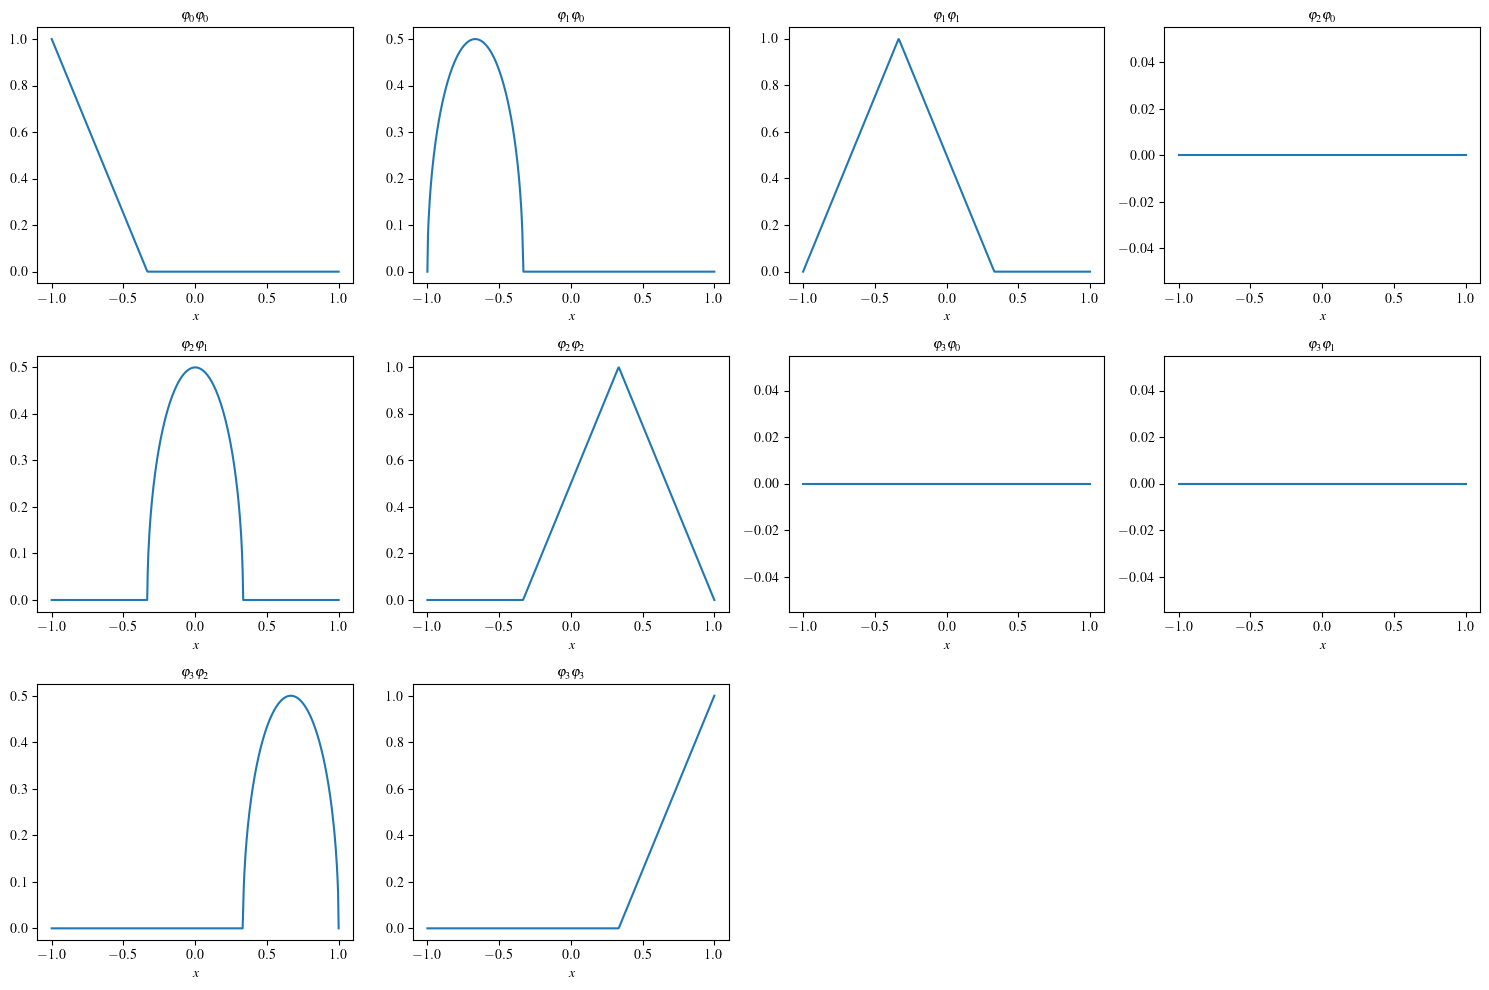

In [2]:
num_qubits = 2
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts)
basis_vectors = hat_basis.eval_basis_vector(xvals)
basis_vectors = torch.sqrt(basis_vectors)

num_subplots = num_nodes * (num_nodes + 1) // 2
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs_flat = axs.flatten()

subplot_idx = 0
for i in range(num_nodes):
    for j in range(i + 1):
        axs_flat[subplot_idx].plot(xvals, basis_vectors[:, i] * basis_vectors[:, j])
        axs_flat[subplot_idx].set_title(f'$\\varphi_{i}\\varphi_{j}$')
        axs_flat[subplot_idx].set_xlabel('$x$')
        subplot_idx += 1

for idx in range(subplot_idx, len(axs_flat)):
    fig.delaxes(axs_flat[idx])

plt.tight_layout()
plt.savefig('./figures/basis_funcs.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [3]:
num_qubits = 5
num_nodes = 2**num_qubits
a = -1.0
b = 1.0
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)

embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
obs = qml.PauliZ(0)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤  <Z>
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤     


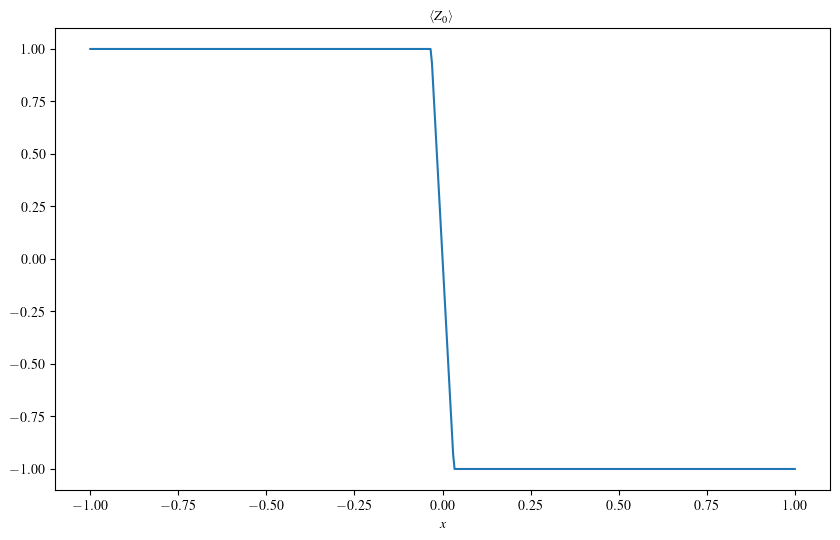

In [4]:
num_pnts = 500
xvals = torch.linspace(-1.0, 1.0, num_pnts).unsqueeze(-1)
yvals = model(xvals)

plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_0\\rangle$")
plt.savefig('./figures/z0.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [5]:
obs = qml.PauliZ(num_qubits-1)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <Z>


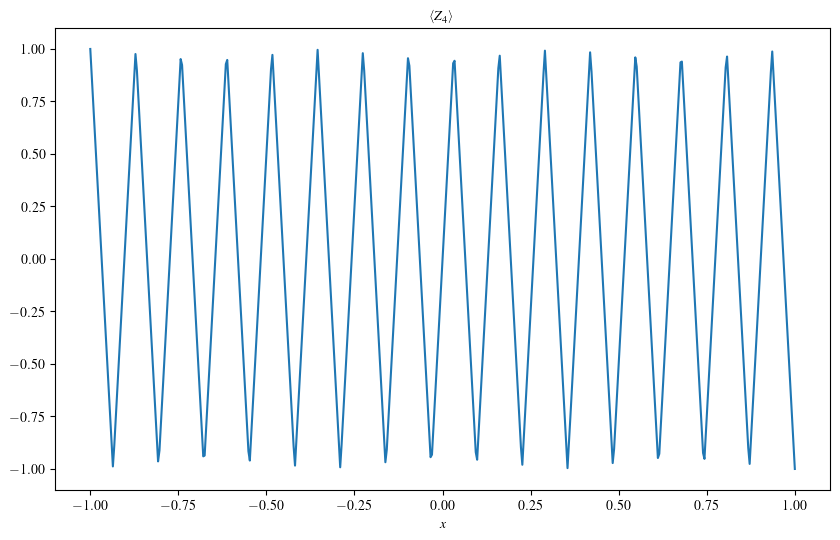

In [6]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle Z_4\\rangle$")
plt.savefig('./figures/zn.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [7]:
obs = qml.PauliX(4)
model = MeasurementLayer(embed, observables=obs, measurement_type=MeasurementType.Expectation)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))

0: ──────────────────────╭U(M2)─┤     
1: ───────────────╭U(M1)─╰U(M2)─┤     
2: ────────╭U(M1)─╰U(M1)────────┤     
3: ─╭U(M0)─╰U(M1)───────────────┤     
4: ─╰U(M0)──────────────────────┤  <X>


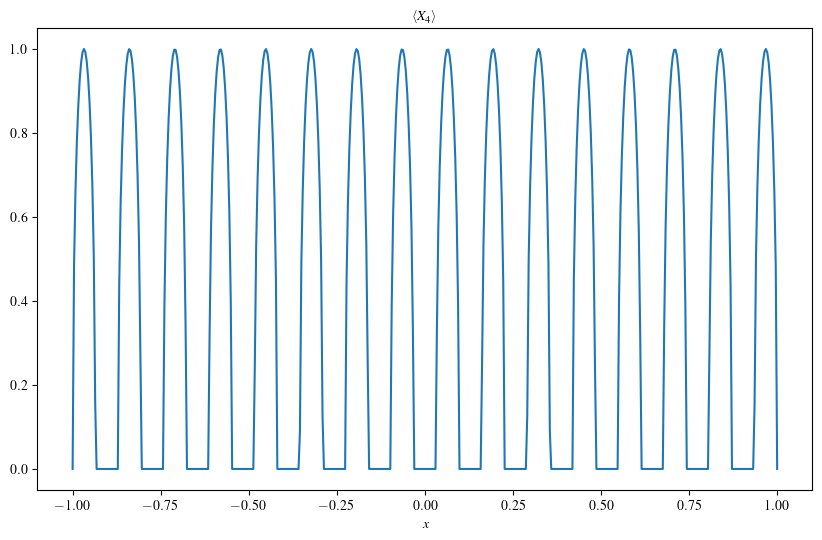

In [8]:
yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.title("$\langle X_4\\rangle$")
plt.savefig('./figures/xn.pdf', format='pdf', bbox_inches='tight')
plt.show()

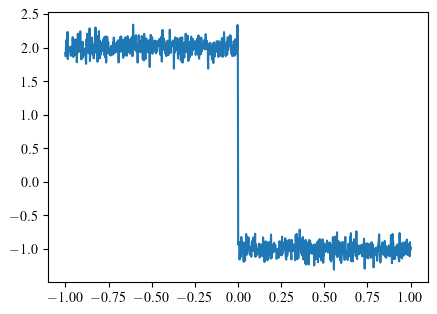

In [9]:
def step_function(
    X, threshold1=-1.0, threshold2=0.0, low_value=0.0, mid_value=2, high_value=-1.0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values

def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    return tensor + torch.randn(tensor.size()) * std + mean

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = step_function
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)
plt.savefig('./figures/stepfunc.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
obs = [qml.Identity(0), qml.PauliZ(0)]
model = HamiltonianLayer(embed, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──────────────────────╭U(M2)─┤  <𝓗(0.57,-0.68)>
1: ───────────────╭U(M1)─╰U(M2)─┤                 
2: ────────╭U(M1)─╰U(M1)────────┤                 
3: ─╭U(M0)─╰U(M1)───────────────┤                 
4: ─╰U(M0)──────────────────────┤                 
Number of parameters:  2


In [11]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [12]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 2.776697, Metrics: MARE: 1.258625
INFO:train_function:Validate - Epoch: 1, Loss: 2.845745, Metrics: MARE: 1.257491
INFO:train_function:Train - Epoch: 2, Loss: 1.427626, Metrics: MARE: 0.894313
INFO:train_function:Validate - Epoch: 2, Loss: 1.457448, Metrics: MARE: 0.893555
INFO:train_function:Train - Epoch: 3, Loss: 0.579042, Metrics: MARE: 0.560626
INFO:train_function:Validate - Epoch: 3, Loss: 0.582022, Metrics: MARE: 0.560185
INFO:train_function:Train - Epoch: 4, Loss: 0.155370, Metrics: MARE: 0.279026
INFO:train_function:Validate - Epoch: 4, Loss: 0.142027, Metrics: MARE: 0.278798
INFO:train_function:Train - Epoch: 5, Loss: 0.027045, Metrics: MARE: 0.080604
INFO:train_function:Validate - Epoch: 5, Loss: 0.005942, Metrics: MARE: 0.059422
INFO:train_function:Train - Epoch: 6, Loss: 0.038687, Metrics: MARE: 0.122910
INFO:train_function:Validate - Epoch: 6, Loss: 0.015165, Metrics: MARE: 0.089967
INFO:train_function:Train - Epoch: 7, Loss: 0.

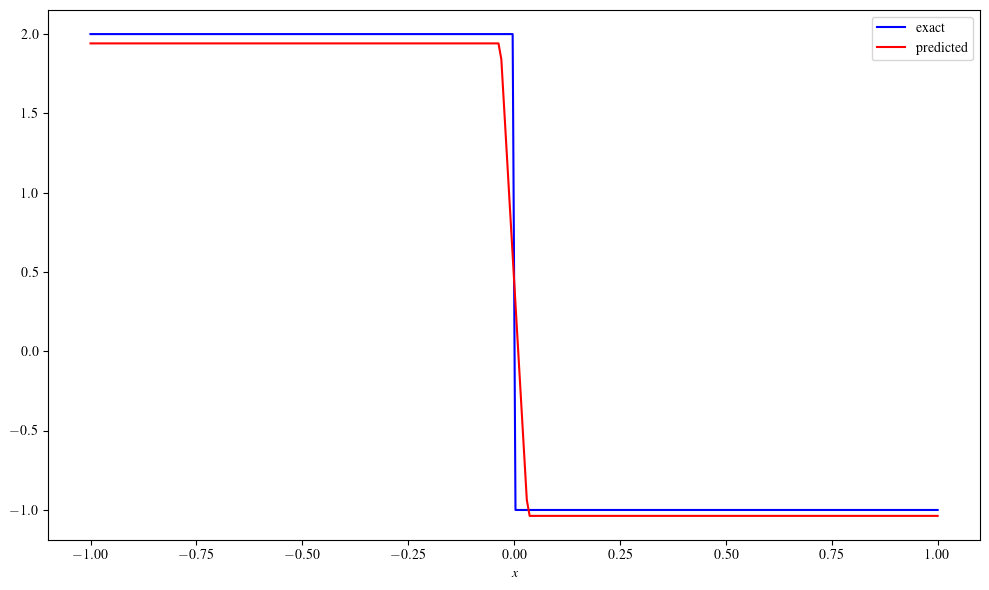

In [13]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/stepfunc_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [14]:
num_features = 1
base = 3.0
omega = 1.0
embed = ParallelIQPEncoding(wires=num_qubits,
                            num_features=num_features,
                            n_repeat=1,
                            base=base,
                            omega=omega)
n_layers = 3
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0), qml.PauliZ(0)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(2.12,4.43,3.17)─╭●──Rot(0.74,5.71,2.75)─────────────────────────╭●
1: ──H──RZ(3.00)───Rot(4.96,5.23,3.54)─╰X──Rot(5.06,0.24,2.48)─╭●──Rot(3.46,1.30,4.63)─╰X
2: ──H──RZ(9.00)───Rot(1.74,6.03,5.57)─╭●──Rot(0.79,1.71,3.49)─╰X──Rot(3.63,6.26,6.16)─╭●
3: ──H──RZ(27.00)──Rot(2.64,4.99,1.70)─╰X──Rot(2.90,2.54,2.23)─╭●──Rot(4.88,2.24,3.22)─╰X
4: ──H──RZ(81.00)──Rot(2.29,4.56,0.24)─────────────────────────╰X──Rot(4.00,3.17,6.04)───

───Rot(4.77,3.19,5.03)─────────────────────────╭●──Rot(0.69,5.64,6.12)─────────────────────────┤
───Rot(4.57,5.97,2.35)─╭●──Rot(4.17,4.54,5.69)─╰X──Rot(2.78,2.29,5.64)─╭●──Rot(0.31,2.03,3.24)─┤
───Rot(5.84,0.43,5.44)─╰X──Rot(0.06,4.24,3.52)─╭●──Rot(0.50,4.88,4.58)─╰X──Rot(3.67,5.27,5.92)─┤
───Rot(4.40,5.84,6.14)─╭●──Rot(0.65,0.57,3.89)─╰X──Rot(1.93,5.16,3.39)─╭●──Rot(5.45,3.21,1.69)─┤
───────────────────────╰X──Rot(3.96,4.04,2.45)─────────────────────────╰X──Rot(0.98,1.44,0.80)─┤

   <𝓗(0.08,-2.96)>
                  
                  
      

In [15]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [16]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.439097, Metrics: MARE: 0.390504
INFO:train_function:Validate - Epoch: 1, Loss: 0.369065, Metrics: MARE: 0.330740
INFO:train_function:Train - Epoch: 2, Loss: 0.384446, Metrics: MARE: 0.378269
INFO:train_function:Validate - Epoch: 2, Loss: 0.340187, Metrics: MARE: 0.374516
INFO:train_function:Train - Epoch: 3, Loss: 0.326648, Metrics: MARE: 0.342705
INFO:train_function:Validate - Epoch: 3, Loss: 0.324414, Metrics: MARE: 0.355347
INFO:train_function:Train - Epoch: 4, Loss: 0.268072, Metrics: MARE: 0.306528
INFO:train_function:Validate - Epoch: 4, Loss: 0.242060, Metrics: MARE: 0.299661
INFO:train_function:Train - Epoch: 5, Loss: 0.243506, Metrics: MARE: 0.273668
INFO:train_function:Validate - Epoch: 5, Loss: 0.208458, Metrics: MARE: 0.250717
INFO:train_function:Train - Epoch: 6, Loss: 0.220114, Metrics: MARE: 0.262734
INFO:train_function:Validate - Epoch: 6, Loss: 0.181237, Metrics: MARE: 0.235019
INFO:train_function:Train - Epoch: 7, Loss: 0.

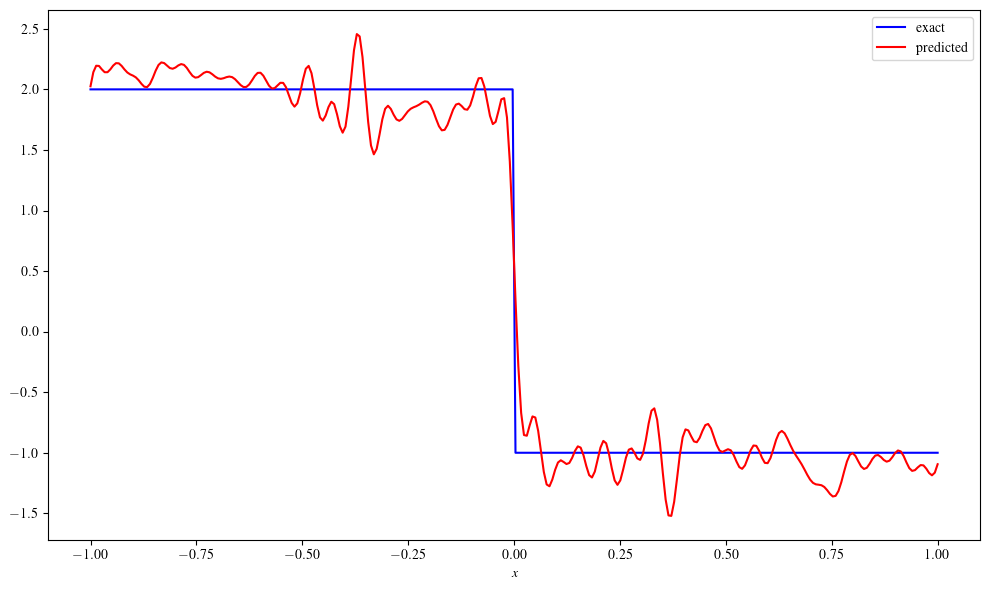

In [17]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/stepfunc_train_iqpe.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

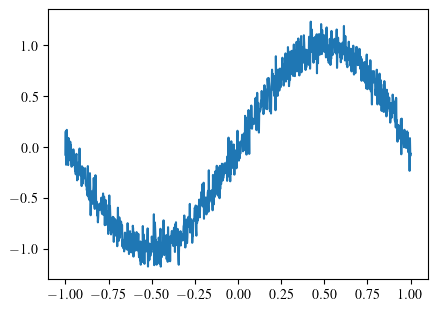

In [18]:
def trigonometric(X, a=1, b=math.pi, c=0.):
    return a * torch.sin(b * X + c)

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = trigonometric
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)
plt.savefig('./figures/sin.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [19]:
embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
num_mps_layers = 1
num_block_layers = 3
reverse = True
var = TwoQubitRotCXMPSLayer(num_qubits, 
                            n_layers_mps=num_mps_layers,
                            n_layers_block=num_block_layers,
                            reverse=reverse)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([0.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──────────────────────────────────────────────────╭U(M2)────────────────Rot(0.79,5.40,1.55)───
1: ─────────────────────────────╭U(M1)───────────────╰U(M2)────────────────Rot(1.16,4.36,4.04)───
2: ────────╭U(M1)───────────────╰U(M1)────────────────Rot(0.53,1.13,5.52)────────────────────────
3: ─╭U(M0)─╰U(M1)────────────────Rot(3.71,4.31,0.06)─╭●────────────────────Rot(5.81,2.73,3.78)─╭●
4: ─╰U(M0)──Rot(0.06,3.46,4.12)──────────────────────╰X────────────────────Rot(3.06,4.88,4.33)─╰X

─────────────────────────────────────────────────────────────────────────────────────────────────
─────────────────────────────────────────────────────────────────────────────────────────────────
───────────────────────────────────────────────╭●──Rot(5.80,5.53,4.75)─╭●──Rot(4.30,5.94,5.65)─╭●
───Rot(2.53,2.88,3.84)─╭●──Rot(1.24,4.40,2.02)─╰X──Rot(4.67,1.43,5.70)─╰X──Rot(5.67,3.84,2.88)─╰X
───Rot(6.02,5.02,1.50)─╰X──Rot(2.61,4.15,0.16)───────────────────────────────────────────────────

──────────────────

In [20]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [21]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 2.834331, Metrics: MARE: 14.790792
INFO:train_function:Validate - Epoch: 1, Loss: 2.714381, Metrics: MARE: 246227.406250
INFO:train_function:Train - Epoch: 2, Loss: 1.379052, Metrics: MARE: 11.294645
INFO:train_function:Validate - Epoch: 2, Loss: 1.342139, Metrics: MARE: 168425.640625
INFO:train_function:Train - Epoch: 3, Loss: 0.512468, Metrics: MARE: 8.303713
INFO:train_function:Validate - Epoch: 3, Loss: 0.606806, Metrics: MARE: 176927.484375
INFO:train_function:Train - Epoch: 4, Loss: 0.178145, Metrics: MARE: 4.398455
INFO:train_function:Validate - Epoch: 4, Loss: 0.238832, Metrics: MARE: 124520.828125
INFO:train_function:Train - Epoch: 5, Loss: 0.133821, Metrics: MARE: 2.875501
INFO:train_function:Validate - Epoch: 5, Loss: 0.113087, Metrics: MARE: 58995.988281
INFO:train_function:Train - Epoch: 6, Loss: 0.094504, Metrics: MARE: 4.460711
INFO:train_function:Validate - Epoch: 6, Loss: 0.041794, Metrics: MARE: 30055.214844
INFO:train_funct

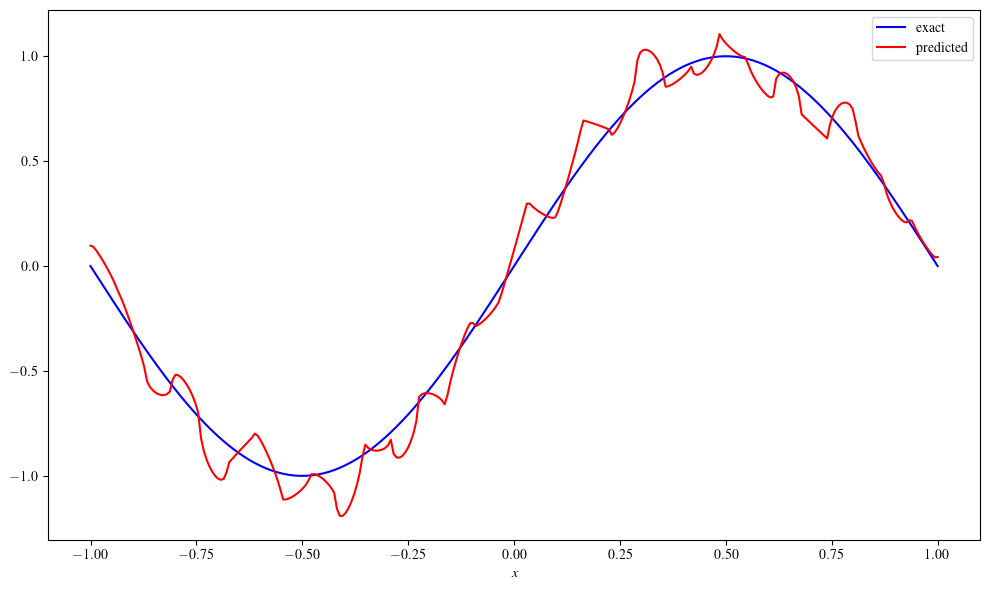

In [22]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/sin_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [23]:
num_features = 1
base = 3.0
omega = 1.0
embed = ParallelIQPEncoding(wires=num_qubits,
                            num_features=num_features,
                            n_repeat=1,
                            base=base,
                            omega=omega)
n_layers = 3
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(5.20,1.17,1.66)─╭●──Rot(3.30,1.64,3.44)─────────────────────────╭●
1: ──H──RZ(3.00)───Rot(1.24,4.95,5.58)─╰X──Rot(3.73,1.79,2.22)─╭●──Rot(1.15,4.81,1.00)─╰X
2: ──H──RZ(9.00)───Rot(0.41,3.68,4.96)─╭●──Rot(1.43,6.19,5.53)─╰X──Rot(3.30,4.29,2.07)─╭●
3: ──H──RZ(27.00)──Rot(5.79,2.19,0.88)─╰X──Rot(0.39,5.96,6.19)─╭●──Rot(0.79,1.40,5.62)─╰X
4: ──H──RZ(81.00)──Rot(0.03,5.11,2.85)─────────────────────────╰X──Rot(1.64,6.08,4.66)───

───Rot(0.21,2.45,5.48)─────────────────────────╭●──Rot(2.61,0.27,1.04)─────────────────────────┤ ╭<𝓗>
───Rot(2.54,3.94,5.68)─╭●──Rot(4.11,1.26,0.53)─╰X──Rot(1.07,2.03,2.34)─╭●──Rot(5.26,0.85,3.94)─┤ ├<𝓗>
───Rot(5.31,2.29,0.50)─╰X──Rot(1.56,2.40,3.20)─╭●──Rot(5.18,1.38,3.30)─╰X──Rot(1.34,4.28,4.87)─┤ ├<𝓗>
───Rot(0.01,0.53,3.37)─╭●──Rot(2.68,4.39,1.72)─╰X──Rot(5.75,4.78,4.99)─╭●──Rot(3.66,0.78,5.84)─┤ ├<𝓗>
───────────────────────╰X──Rot(0.61,0.59,3.75)─────────────────────────╰X──Rot(2.51,2.04,0.72)─┤ ╰<𝓗>
Number of parameters:  93


In [24]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [25]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.331069, Metrics: MARE: 6.147250
INFO:train_function:Validate - Epoch: 1, Loss: 0.309674, Metrics: MARE: 125867.000000
INFO:train_function:Train - Epoch: 2, Loss: 0.155253, Metrics: MARE: 2.526852
INFO:train_function:Validate - Epoch: 2, Loss: 0.113134, Metrics: MARE: 64076.664062
INFO:train_function:Train - Epoch: 3, Loss: 0.101314, Metrics: MARE: 1.234270
INFO:train_function:Validate - Epoch: 3, Loss: 0.040868, Metrics: MARE: 22978.216797
INFO:train_function:Train - Epoch: 4, Loss: 0.064860, Metrics: MARE: 3.115956
INFO:train_function:Validate - Epoch: 4, Loss: 0.054864, Metrics: MARE: 68716.117188
INFO:train_function:Train - Epoch: 5, Loss: 0.033843, Metrics: MARE: 1.773245
INFO:train_function:Validate - Epoch: 5, Loss: 0.031696, Metrics: MARE: 25723.625000
INFO:train_function:Train - Epoch: 6, Loss: 0.033518, Metrics: MARE: 0.998453
INFO:train_function:Validate - Epoch: 6, Loss: 0.018450, Metrics: MARE: 13082.464844
INFO:train_function:T

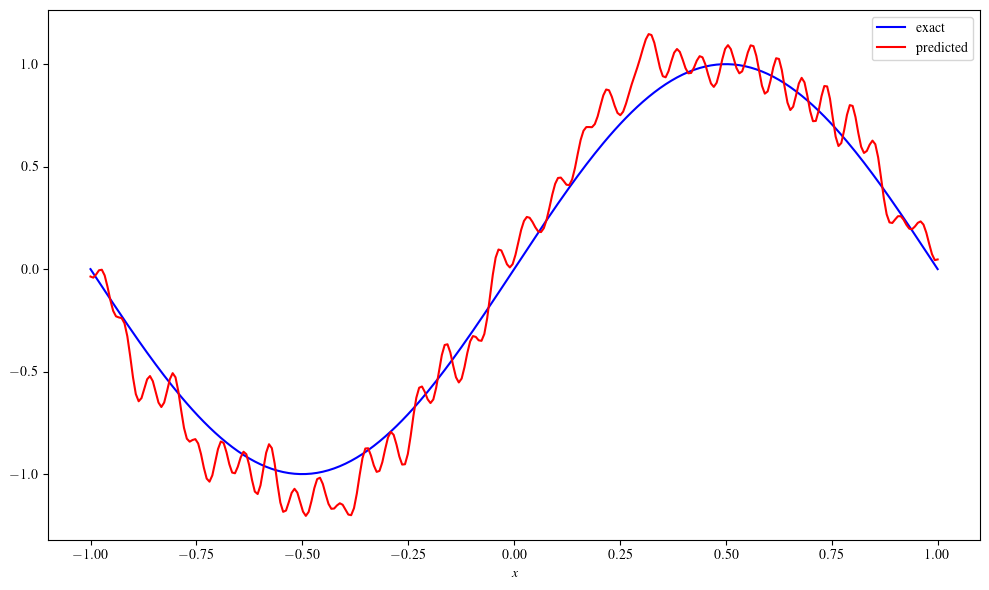

In [26]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/sin_train_iqpe.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [27]:
n_layers = 1
var = AltRotCXLayer(wires=num_qubits, n_layers=n_layers)

obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([1.0])
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

0: ──H──RZ(1.00)───Rot(0.38,1.11,0.60)─╭●──Rot(2.04,5.53,3.54)─────────────────────────┤ ╭<𝓗>
1: ──H──RZ(3.00)───Rot(0.73,5.74,0.85)─╰X──Rot(2.02,2.85,4.45)─╭●──Rot(0.35,1.08,4.75)─┤ ├<𝓗>
2: ──H──RZ(9.00)───Rot(1.64,1.03,0.83)─╭●──Rot(5.54,5.03,1.47)─╰X──Rot(4.18,4.68,0.86)─┤ ├<𝓗>
3: ──H──RZ(27.00)──Rot(0.07,3.66,4.25)─╰X──Rot(3.25,2.61,2.51)─╭●──Rot(2.49,5.39,3.62)─┤ ├<𝓗>
4: ──H──RZ(81.00)──Rot(5.38,1.21,4.82)─────────────────────────╰X──Rot(3.14,0.18,0.86)─┤ ╰<𝓗>
Number of parameters:  45


In [28]:
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [29]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.177854, Metrics: MARE: 1.501982
INFO:train_function:Validate - Epoch: 1, Loss: 0.149469, Metrics: MARE: 14218.181641
INFO:train_function:Train - Epoch: 2, Loss: 0.095892, Metrics: MARE: 1.679639
INFO:train_function:Validate - Epoch: 2, Loss: 0.073402, Metrics: MARE: 26895.365234
INFO:train_function:Train - Epoch: 3, Loss: 0.024791, Metrics: MARE: 1.158555
INFO:train_function:Validate - Epoch: 3, Loss: 0.034858, Metrics: MARE: 50416.726562
INFO:train_function:Train - Epoch: 4, Loss: 0.034318, Metrics: MARE: 1.595108
INFO:train_function:Validate - Epoch: 4, Loss: 0.045559, Metrics: MARE: 50768.585938
INFO:train_function:Train - Epoch: 5, Loss: 0.020207, Metrics: MARE: 1.017880
INFO:train_function:Validate - Epoch: 5, Loss: 0.025235, Metrics: MARE: 22668.251953
INFO:train_function:Train - Epoch: 6, Loss: 0.019161, Metrics: MARE: 1.278102
INFO:train_function:Validate - Epoch: 6, Loss: 0.016252, Metrics: MARE: 40212.195312
INFO:train_function:Tr

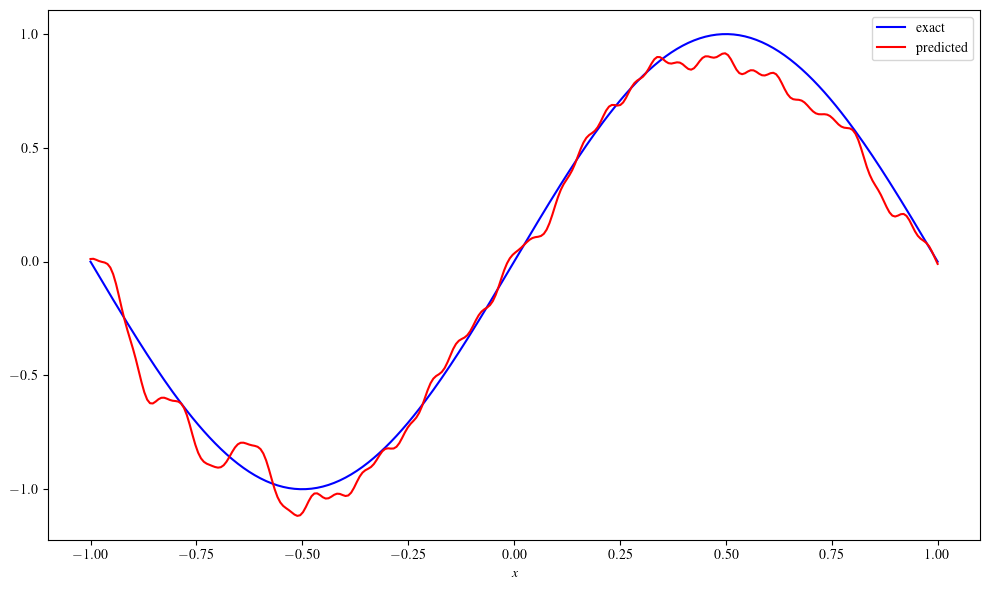

In [30]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/sin_train_iqpe_l0.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [31]:
num_qubits = 5
def construct_matrix(c):
    size = 2**num_qubits
    H = np.zeros((size, size), dtype=complex)
    np.fill_diagonal(H[:2], 1)
    np.fill_diagonal(H[-2:], -1)

    counter = 0
    for i in range(size):
        for j in range(i+1, size):
            H[i, j] = complex(0, c[counter])
            counter += 1

    H = H + H.conj().T - np.diag(H.diagonal())
    return H

def objective_function(c):
    H = construct_matrix(c)
    size = H.shape[0]
    half = int(size/2)
    eigenvalues = np.linalg.eigvalsh(H)
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]
    target_eigenvalues = [1]*half+[-1]*half
    
    error = np.sum((eigenvalues_sorted - target_eigenvalues)**2)
    return error

num_params = (2**num_qubits * (2**num_qubits - 1)) // 2
initial_guesses = np.ones(num_params)
result = sp.optimize.minimize(objective_function, initial_guesses, method='BFGS')

optimized_c = result.x
print("Cost value:", result.fun)

H = construct_matrix(optimized_c)
eigs, U = np.linalg.eigh(H)
print(eigs)

Cost value: 1.0557280902123383
[-1.00000425 -1.00000176 -1.00000105 -1.00000063 -1.00000044 -1.00000013
 -0.99999987 -0.99999966 -0.99999941 -0.99999901 -0.9999989  -0.99999868
 -0.99999836 -0.99999774 -0.61803559 -0.61803239  0.99999774  0.99999836
  0.99999868  0.9999989   0.99999901  0.99999941  0.99999966  0.99999987
  1.00000013  1.00000044  1.00000063  1.00000105  1.00000176  1.00000425
  1.61803294  1.61803504]


In [32]:
a = -1.0
b = 1.0
num_nodes = 2**num_qubits
hat_basis = HatBasis(a=a, b=b, num_nodes=num_nodes)      
embed = HatBasisQFE(wires=num_qubits, basis=hat_basis, sqrt=True, normalize=False)
var = EmbedU(num_qubits, U.conj().T)

obs = [qml.PauliZ(0)]
model = HamiltonianLayer(embed, var, observables=obs)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.tensor([-0.1429])
y = model(x)
print(y)
print(drawer(x))
nump = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", nump)

tensor([-7.8410e-14], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
0: ──────────────────────╭U(M2)─╭U(M3)─┤  <𝓗(-1.11)>
1: ───────────────╭U(M1)─╰U(M2)─├U(M3)─┤            
2: ────────╭U(M1)─╰U(M1)────────├U(M3)─┤            
3: ─╭U(M0)─╰U(M1)───────────────├U(M3)─┤            
4: ─╰U(M0)──────────────────────╰U(M3)─┤            
Number of parameters:  1


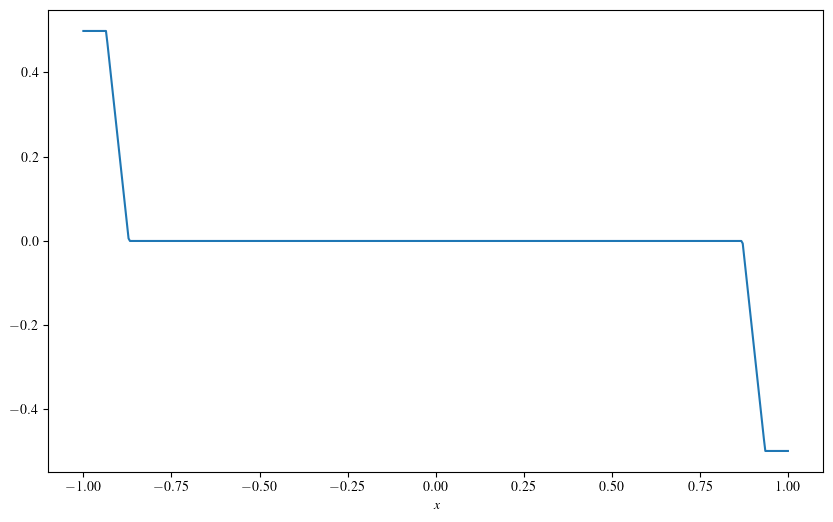

In [33]:
with torch.no_grad():
    yvals = model(xvals)
plt.figure(figsize=(10, 6))
plt.plot(xvals, yvals)
plt.xlabel('$x$')
plt.show()

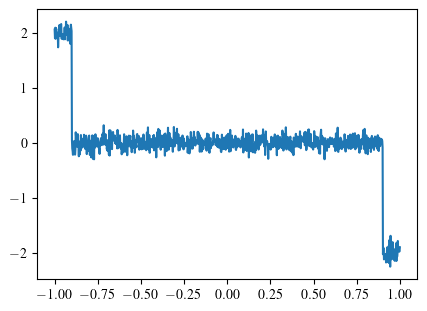

In [34]:
def step_function(
    X, threshold1=-0.9, threshold2=0.9, low_value=2.0, mid_value=0, high_value=-2.0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values

X = torch.linspace(-1, 1, 1000).reshape(-1, 1)
func = step_function
sigma = 0.1
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)
plt.savefig('./figures/segments.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [35]:
N_train = 50
N_valid = 10
batch_size = 10
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

lr = 0.1
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)

num_epochs = 100
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [36]:
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.277149, Metrics: MARE: 1.034550
INFO:train_function:Validate - Epoch: 1, Loss: 0.365598, Metrics: MARE: 0.135204
INFO:train_function:Train - Epoch: 2, Loss: 0.224052, Metrics: MARE: 1.054812
INFO:train_function:Validate - Epoch: 2, Loss: 0.276560, Metrics: MARE: 0.117593
INFO:train_function:Train - Epoch: 3, Loss: 0.175565, Metrics: MARE: 1.075874
INFO:train_function:Validate - Epoch: 3, Loss: 0.197154, Metrics: MARE: 0.099286
INFO:train_function:Train - Epoch: 4, Loss: 0.137718, Metrics: MARE: 1.094859
INFO:train_function:Validate - Epoch: 4, Loss: 0.137067, Metrics: MARE: 0.082785
INFO:train_function:Train - Epoch: 5, Loss: 0.110824, Metrics: MARE: 1.110429
INFO:train_function:Validate - Epoch: 5, Loss: 0.095915, Metrics: MARE: 0.069252
INFO:train_function:Train - Epoch: 6, Loss: 0.086998, Metrics: MARE: 1.126490
INFO:train_function:Validate - Epoch: 6, Loss: 0.061144, Metrics: MARE: 0.055292
INFO:train_function:Train - Epoch: 7, Loss: 0.

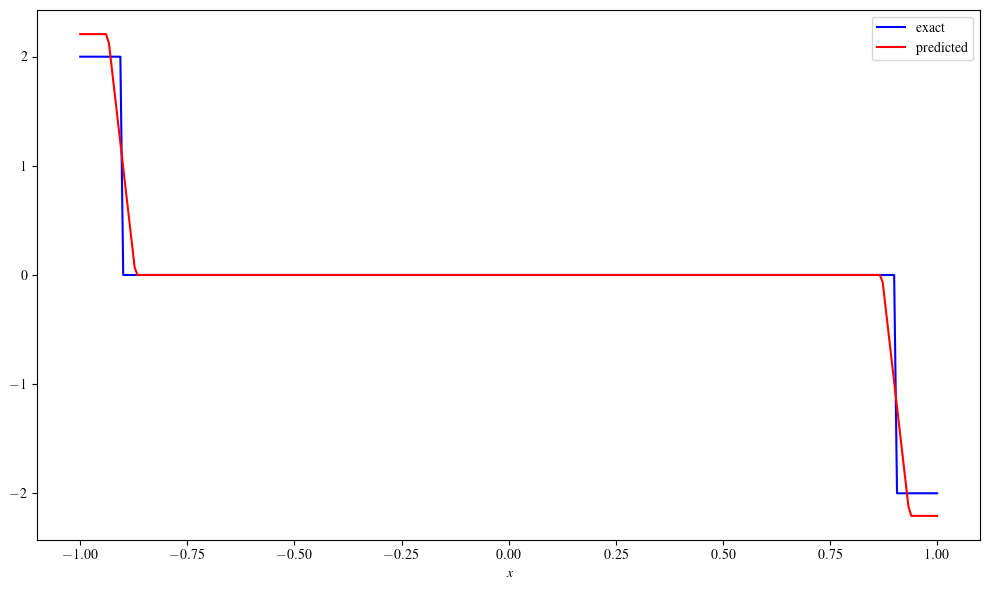

In [37]:
X = torch.linspace(-1, 1, 300, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")
plt.xlabel("$x$")
plt.legend()
plt.savefig('./figures/twosteps_train_pptnqfe.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()